# This notebook contains the code to train SynthMorph with random 2D label maps with different structures

## 1. Import of all the libraries and packages needed to run the code

In [1]:
import numpy as np
import odl
import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm

2023-08-23 13:28:02.037388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 13:28:02.494772: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mamo/devel/build/INSTALL/lib:/home/mamo/devel/build/INSTALL/lib64::
2023-08-23 13:28:02.494826: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-23 13:28:04.019649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7

## 2. Behaviour of the loss function over few epochs if we train SynthMorph with 2D label maps of the same size as the label maps containing the sinograms: (368x512) (refer to the synthmorph_trained_with_3Dsinograms_pairs.ipynb notebook )

### 2.1. Creation of 100 data pairs

In [2]:
# Input shapes.
in_shape = (368, 512) # Label maps dimensions.
num_dim = len(in_shape)
num_label = 16
num_maps = 100 # The number of data pairs we want to train the model with.

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    warped_im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    label_maps.append(np.uint8(lab))
    warped_lab = tf.argmax(warped_im, axis=-1)
    label_maps.append(np.uint8(warped_lab))
    # The label_maps list contains all the data pairs generated above.


  0%|                                                                                                                                                                                      | 0/100 [00:00<?, ?it/s]2023-08-23 13:28:09.798017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mamo/devel/build/INSTALL/lib:/home/mamo/devel/build/INSTALL/lib64::
2023-08-23 13:28:09.798194: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mamo/devel/build/INSTALL/lib:/home/mamo/devel/build/INSTALL/lib64::
2023-08-23 13:28:09.798349: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dyn

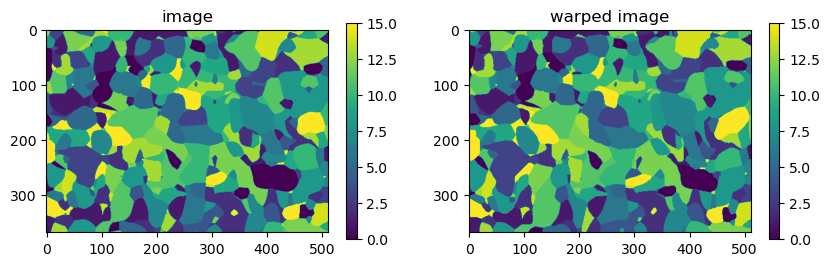

In [3]:
# Visualise one image and its warped version
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(lab[:,:])
plt.title("image")
plt.colorbar(shrink = 0.40)

fig.add_subplot(rows, columns, 2)
plt.imshow(warped_lab[:,:])
plt.title("warped image")
plt.colorbar(shrink = 0.40)

### 2.2. Creation of 200 grey-scale images to train the model

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1/1 [==============================] - 0s 48ms/step


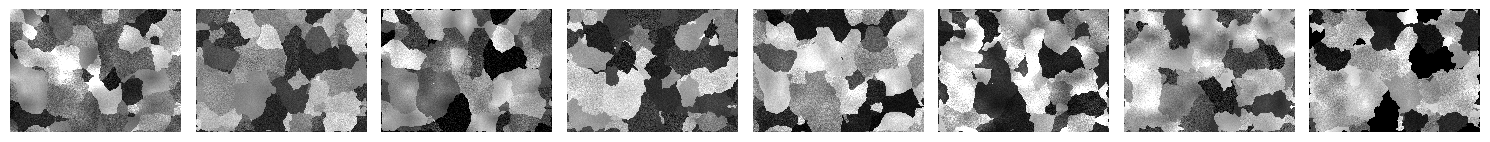

In [5]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape=in_shape,
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
# We separate the grey-scale images created from the label_maps list into two different lists: 
# one containing the grey-scale images corresponding to the "fixed" images and 
# another containing those corresponding to the "moving" images.
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)


# Test repeatedly for single input.
# We can see several image contrasts from a given image (here from the first "fixed" grey-scale image).
num_gen = 8
input = np.expand_dims(label_maps[0], axis=(0, -1))
slices = [gen_model_1.predict(input)[0] for _ in range(num_gen)]
ne.plot.slices(slices);

### 2.3. Creation of the model

In [6]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape=in_shape,
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([512]*4, [368]*8),
    reg_field='warp',
)


# Model for optimisation.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)
# The inputs in a Keras model are used to define the placeholders or containers for the input data that will 
# be fed into the model during training or inference. 
# They represent the expected shape and type of the input data.

# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

### 2.4. Train SynthMorph over few epochs

Epoch 6/60
100/100 [==============================] - 924s 9s/step - loss: 0.2263
Epoch 7/60
100/100 [==============================] - 923s 9s/step - loss: 0.2163
Epoch 8/60
100/100 [==============================] - 922s 9s/step - loss: 0.2133
Epoch 9/60
100/100 [==============================] - 923s 9s/step - loss: 0.2151
Epoch 10/60
100/100 [==============================] - 923s 9s/step - loss: 0.2128
Epoch 11/60
100/100 [==============================] - 922s 9s/step - loss: 0.2123
Epoch 12/60
100/100 [==============================] - 922s 9s/step - loss: 0.1995
Epoch 13/60
100/100 [==============================] - 922s 9s/step - loss: 0.1906
Epoch 14/60
100/100 [==============================] - 920s 9s/step - loss: 0.2030
Epoch 15/60
100/100 [==============================] - 921s 9s/step - loss: 0.1955
Epoch 16/60
100/100 [==============================] - 919s 9s/step - loss: 0.1915
Epoch 17/60
100/100 [==============================] - 919s 9s/step - loss: 0.1916
Epoch 18

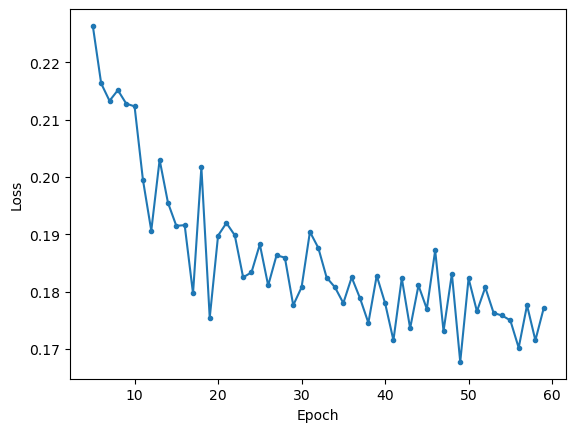

In [8]:
# Train model for a few epochs. 
# Re-running the cell will continue training.
gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1, # Number of samples per gradient update.
    same_subj=True,
    flip=True,
)

hist = model.fit(
    gen,
    initial_epoch=5,
    epochs=60,
    steps_per_epoch=100,
    verbose=1, # Visualise the progress bar.
)


# Visualise loss.
plt.plot(hist.epoch, hist.history['loss'], '.-');
plt.xlabel('Epoch');
plt.ylabel('Loss');

## 3. Behaviour of the loss function over few epochs if we train SynthMorph with 2D label maps of size 1x512 to witch we add 15 lines with a value of 0

### 3.1. Creation of 10 data pairs

In [ ]:
# Input shapes.
in_shape = (1, 512) # Label maps dimensions.
num_dim = len(in_shape)
num_label = 16
num_maps = 10 # The number of data pairs we want to train the model with.

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    warped_im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    # Creation of an image full of 0 with dimensions multiples of 16.
    lab_bis = np.zeros((16, 512), dtype=np.uint8)
    # Insertion of the label map in the middle of the image.
    lab_bis[8,:] = lab    
    label_maps.append(np.uint8(lab_bis))
    warped_lab = tf.argmax(warped_im, axis=-1)
    # Creation of an image full of 0 with dimensions multiples of 16.
    warped_lab_bis = np.zeros((16, 512), dtype=np.uint8)
    # Insertion of the label map in the middle of the image.
    warped_lab_bis[8,:] = warped_lab
    label_maps.append(np.uint8(warped_lab_bis))

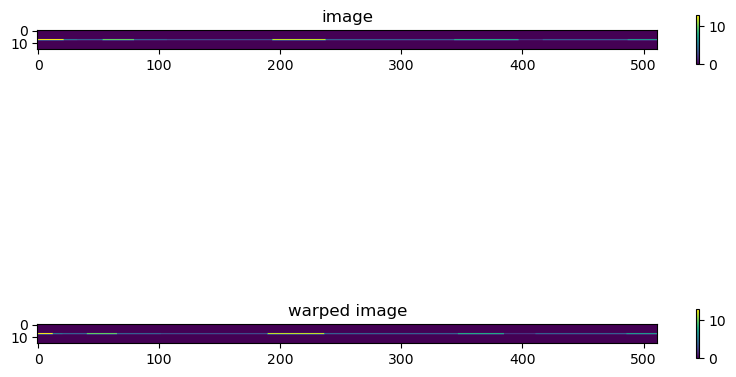

In [5]:
# Visualise one image and its warped version.
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(lab_bis[:,:])
plt.title("image")
plt.colorbar(shrink = 0.2)

fig.add_subplot(rows, columns, 2)
plt.imshow(warped_lab_bis[:,:])
plt.title("warped image")
plt.colorbar(shrink = 0.2)

### 3.2. Creation of 20 grey-scale images to train the model

In [6]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape=(16, 512), # shape of the image (must be a multiple of 16)
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
# We separate the grey-scale images created from the label_maps list into two different lists: 
# one containing the grey-scale images corresponding to the "fixed" images and 
# another containing those corresponding to the "moving" images.
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)


# Test repeatedly for single input.
# We can see several image contrasts from a given image (here from the first "fixed" grey-scale image).
num_gen = 8
input = np.expand_dims(label_maps[0], axis=(0, -1))
slices = [gen_model_1.predict(input)[0] for _ in range(num_gen)]
ne.plot.slices(slices);

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1/1 [==============================] - 0s 28ms/step


### 3.3. Creation of the model

In [7]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape=(16, 512), # Shape of the image (must be a multiple of 16).
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([512]*4, [16]*8),
    reg_field='warp',
)

# Define regularisation strength.
regularisation_strength = 0

# Get the regularisation losses from the VxmDense layer.
regularisation_loss = tf.reduce_sum(reg_model.losses)

# Define the custom loss function with regularisation.
def custom_loss(y_true, y_pred):
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss += regularisation_strength * regularisation_loss
    return loss

reg_model.compile(loss=custom_loss)

# Model for optimisation.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)
# The inputs in a Keras model are used to define the placeholders or containers for the input data that will 
# be fed into the model during training or inference. 
# They represent the expected shape and type of the input data.

# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

### 3.4. Train SynthMorph over few epochs

In [8]:
# Train model for a few epochs. 
# Re-running the cell will continue training.
gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1, # Number of samples per gradient update.
    same_subj=True,
    flip=True,
)

hist = model.fit(
    gen,
    initial_epoch=0,
    epochs=300,
    steps_per_epoch=100,
    verbose=1, # Visualise the progress bar.
)

Epoch 1/300
  1/100 [..............................] - ETA: 30:26 - loss: 0.9137

2023-07-17 12:15:02.942135: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 31850496 exceeds 10% of free system memory.
2023-07-17 12:15:02.945070: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 28311552 exceeds 10% of free system memory.
2023-07-17 12:15:02.945744: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 28311552 exceeds 10% of free system memory.
2023-07-17 12:15:02.946356: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 28311552 exceeds 10% of free system memory.
2023-07-17 12:15:02.946975: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 28311552 exceeds 10% of free system memory.


100/100 [==============================] - 38s 200ms/step - loss: 0.9078
Epoch 2/300
100/100 [==============================] - 20s 199ms/step - loss: 0.9079
Epoch 3/300
100/100 [==============================] - 20s 204ms/step - loss: 0.9083
Epoch 4/300
100/100 [==============================] - 20s 198ms/step - loss: 0.9103
Epoch 5/300
100/100 [==============================] - 20s 199ms/step - loss: 0.9110
Epoch 6/300
100/100 [==============================] - 20s 199ms/step - loss: 0.9115
Epoch 7/300
100/100 [==============================] - 20s 203ms/step - loss: 0.9073
Epoch 8/300
100/100 [==============================] - 20s 199ms/step - loss: 0.9111
Epoch 9/300
100/100 [==============================] - 20s 200ms/step - loss: 0.9057
Epoch 10/300
100/100 [==============================] - 20s 198ms/step - loss: 0.9074
Epoch 11/300
100/100 [==============================] - 20s 203ms/step - loss: 0.9114
Epoch 12/300
100/100 [==============================] - 20s 199ms/step - lo

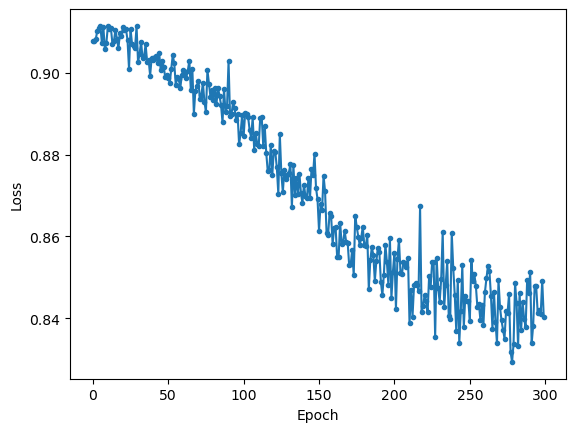

In [9]:
# Visualise loss.
plt.plot(hist.epoch, hist.history['loss'], '.-');
plt.xlabel('Epoch');
plt.ylabel('Loss');

## 4. Behaviour of the loss function over few epochs if we train SynthMorph with 2D label maps of size 1x512 to witch we add 15 lines with a value of 3

### 4.1. Creation of 10 data pairs

In [47]:
# Input shapes.
in_shape = (1, 512) # Label maps dimensions.
num_dim = len(in_shape)
num_label = 16
num_maps = 10 # The number of data pairs we want to train the model with.

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    warped_im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    # Creation of an image full of 3 with dimensions multiples of 16.
    lab_bis = np.full((16, 512), 3, dtype=np.uint8)
    # Insertion of the label map in the middle of the image.
    lab_bis[8,:] = lab    
    label_maps.append(np.uint8(lab_bis))
    warped_lab = tf.argmax(warped_im, axis=-1)
    # Creation of an image full of 3 with dimensions multiples of 16.
    warped_lab_bis = np.full((16, 512), 3, dtype=np.uint8)
    # Insertion of the label map in the middle of the image.
    warped_lab_bis[8,:] = warped_lab
    label_maps.append(np.uint8(warped_lab_bis))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]


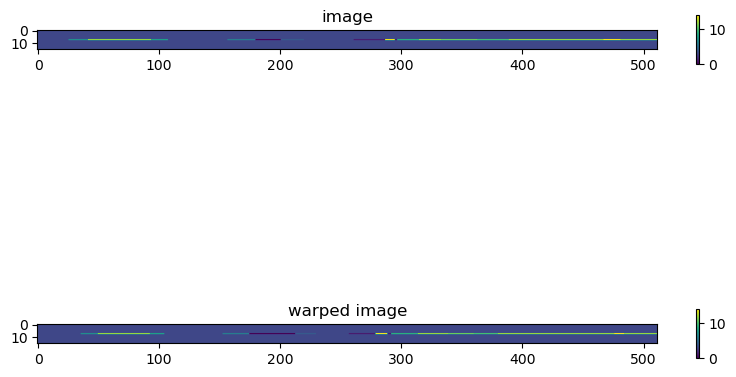

In [48]:
# Visualise one image and its warped version
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(lab_bis[:,:])
plt.title("image")
plt.colorbar(shrink = 0.2)

fig.add_subplot(rows, columns, 2)
plt.imshow(warped_lab_bis[:,:])
plt.title("warped image")
plt.colorbar(shrink = 0.2)

### 4.2. Creation of 20 grey-scale images to train the model

In [49]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape=(16, 512),
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
# We separate the grey-scale images created from the label_maps list into two different lists: 
# one containing the grey-scale images corresponding to the "fixed" images and 
# another containing those corresponding to the "moving" images.
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)


# Test repeatedly for single input.
# We can see several image contrasts from a given image (here from the first "fixed" grey-scale image).
num_gen = 8
input = np.expand_dims(label_maps[0], axis=(0, -1))
slices = [gen_model_1.predict(input)[0] for _ in range(num_gen)]
ne.plot.slices(slices);

1/1 [==============================] - 0s 28ms/step


### 4.3. Creation of the model

In [50]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape=(16, 512), # Shape of the image (must be a multiple of 16).
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([512]*4, [16]*8),
    reg_field='warp',
)

# Define regularisation strength.
regularisation_strength = 0

# Get the regularisation losses from the VxmDense layer.
regularisation_loss = tf.reduce_sum(reg_model.losses)

# Define the custom loss function with regularisation.
def custom_loss(y_true, y_pred):
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss += regularisation_strength * regularisation_loss
    return loss

reg_model.compile(loss=custom_loss)

# Model for optimisation.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)
# The inputs in a Keras model are used to define the placeholders or containers for the input data that will 
# be fed into the model during training or inference. 
# They represent the expected shape and type of the input data.

# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

### 4.4. Train SynthMorph over few epochs

In [51]:
# Train model for a few epochs. 
# Re-running the cell will continue training.
gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1, # Number of samples per gradient update.
    same_subj=True,
    flip=True,
)

hist = model.fit(
    gen,
    initial_epoch=0,
    epochs=300,
    steps_per_epoch=100,
    verbose=1, # Visualise the progress bar.
)

Epoch 1/300
100/100 [==============================] - 39s 207ms/step - loss: 0.9064
Epoch 2/300
100/100 [==============================] - 21s 209ms/step - loss: 0.9061
Epoch 3/300
100/100 [==============================] - 21s 208ms/step - loss: 0.9068
Epoch 4/300
100/100 [==============================] - 20s 200ms/step - loss: 0.9029
Epoch 5/300
100/100 [==============================] - 20s 201ms/step - loss: 0.9051
Epoch 6/300
100/100 [==============================] - 20s 200ms/step - loss: 0.9089
Epoch 7/300
100/100 [==============================] - 20s 203ms/step - loss: 0.9064
Epoch 8/300
100/100 [==============================] - 20s 202ms/step - loss: 0.9023
Epoch 9/300
100/100 [==============================] - 20s 201ms/step - loss: 0.9088
Epoch 10/300
100/100 [==============================] - 20s 204ms/step - loss: 0.9044
Epoch 11/300
100/100 [==============================] - 20s 201ms/step - loss: 0.9073
Epoch 12/300
100/100 [==============================] - 20s 202

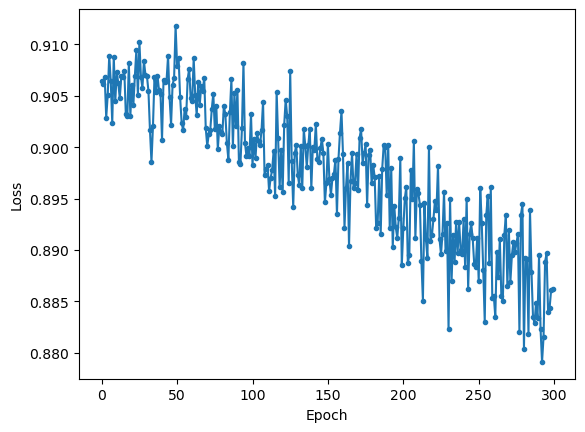

In [52]:
# Visualise loss.
plt.plot(hist.epoch, hist.history['loss'], '.-');
plt.xlabel('Epoch');
plt.ylabel('Loss');

## 5. Behaviour of the loss function over few epochs if we train SynthMorph with 2D label maps of size 368x512 to witch we add 8 lines with a value of 0 (the same structure than the sinograms we used to train the model, refer to synthmorph_trained_with_3Dsinograms_pairs.ipynb notebook)

### 5.1. Creation of 10 data pairs

In [10]:
# Input shapes.
in_shape = (360, 512) # Label maps dimensions.
num_dim = len(in_shape)
num_label = 16
num_maps = 10 # The number of data pairs we want to train the model with.

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    warped_im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    # Creation of an image full of 0 with dimensions multiples of 16.
    lab_bis = np.zeros((368, 512), dtype=np.uint8)
    # Insertion of the image in the middle of the image.
    lab_bis[4:364,:] = lab    
    label_maps.append(np.uint8(lab_bis))
    warped_lab = tf.argmax(warped_im, axis=-1)
    # Creation of an image full of 0 with dimensions multiples of 16.
    warped_lab_bis = np.zeros((368, 512), dtype=np.uint8)
    # Insertion of the image in the middle of the image.
    warped_lab_bis[4:364,:] = warped_lab
    label_maps.append(np.uint8(warped_lab_bis))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


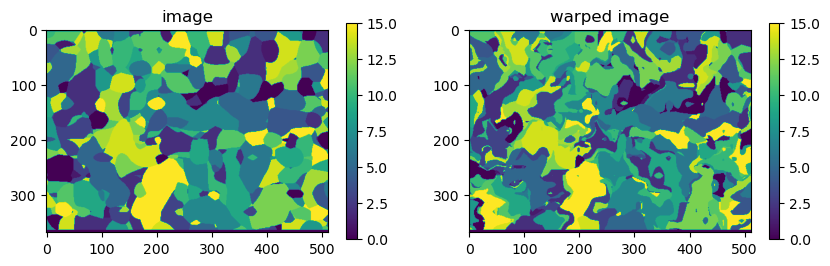

In [11]:
# Visualise one image and its warped version.
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(lab_bis[:,:])
plt.title("image")
plt.colorbar(shrink = 0.4)

fig.add_subplot(rows, columns, 2)
plt.imshow(warped_lab_bis[:,:])
plt.title("warped image")
plt.colorbar(shrink = 0.4)

### 5.2. Creation of 20 grey-scale images to train the model

1/1 [==============================] - 0s 46ms/step


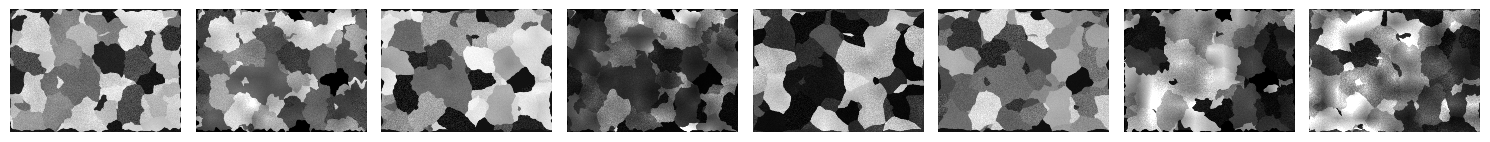

In [12]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape=(368, 512),
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
# We separate the grey-scale images created from the label_maps list into two different lists: 
# one containing the grey-scale images corresponding to the "fixed" images and 
# another containing those corresponding to the "moving" images.
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)


# Test repeatedly for single input.
# We can see several image contrasts from a given image (here from the first "fixed" grey-scale image).
num_gen = 8
input = np.expand_dims(label_maps[0], axis=(0, -1))
slices = [gen_model_1.predict(input)[0] for _ in range(num_gen)]
ne.plot.slices(slices);

### 5.3. Creation of the model

In [13]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape=(368, 512), # Shape of the image (must be a multiple of 16).
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([512]*4, [368]*8),
    reg_field='warp',
)

# Define regularisation strength.
regularisation_strength = 0

# Get the regularisation losses from the VxmDense layer.
regularisation_loss = tf.reduce_sum(reg_model.losses)

# Define the custom loss function with regularisation.
def custom_loss(y_true, y_pred):
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss += regularisation_strength * regularisation_loss
    return loss

reg_model.compile(loss=custom_loss)

# Model for optimisation.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)
# The inputs in a Keras model are used to define the placeholders or containers for the input data that will 
# be fed into the model during training or inference. 
# They represent the expected shape and type of the input data.


# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

### 5.4. Train SynthMorph over few epochs

In [ ]:
# Train model for a few epochs. 
# Re-running the cell will continue training.
gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1, # Number of samples per gradient update.
    same_subj=True,
    flip=True,
)

hist = model.fit(
    gen,
    initial_epoch=0,
    epochs=100,
    steps_per_epoch=100,
    verbose=1, # Visualise the progress bar.
)

Epoch 1/100
 16/100 [===>..........................] - ETA: 12:47 - loss: 0.2547

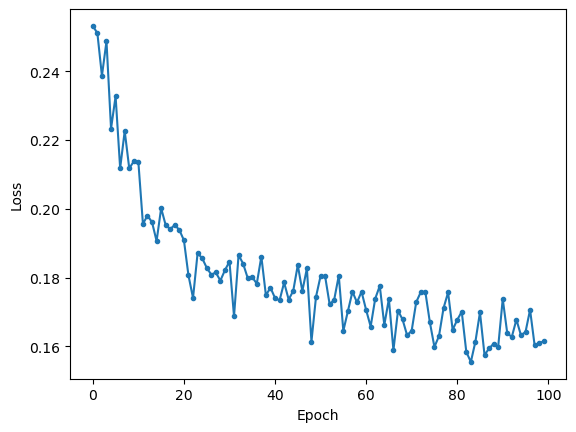

In [16]:
# Visualise loss.
plt.plot(hist.epoch, hist.history['loss'], '.-');
plt.xlabel('Epoch');
plt.ylabel('Loss');